<a href="https://colab.research.google.com/github/seanmcalevey/kaggle_challenges/blob/master/imbd_rating_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Recommender (Text Vectorization)

## 1.0 Load Data into DF

### Basic Imports (Colab)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


### Main DF

In [233]:
drive_path = '/content/drive/My Drive/'
folder_path = 'kaggle_datasets/movies_dataset/'
file_path = 'movies_metadata.csv'
metadata_df = pd.read_csv(drive_path + folder_path + file_path)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Trim Down Dataset Features

In [260]:
cols_to_keep = ['original_title', 'overview', 'original_language', 'spoken_languages', 'vote_count', 'budget', 'genres', 'popularity', 'production_companies',
                'revenue', 'runtime', 'vote_average', 'release_date']
overview_df = metadata_df[cols_to_keep]
overview_df = overview_df[overview_df['original_language'] == 'en'] # only english movies
overview_df = overview_df.drop('original_language', axis=1) # drop language feature
overview_df = overview_df.dropna(subset=['overview']) # drop nans
overview_df = overview_df.reset_index(drop=True)
overview_df.shape

(32200, 12)

### Convert to Propert Dtypes

In [261]:
overview_df['budget'] = overview_df['budget'].astype(float)
overview_df['popularity'] = overview_df['popularity'].astype(float)

### Only English-Lang. Movies

In [262]:
import re

idxs = [i for i, language in enumerate(overview_df['spoken_languages']) if re.search('English', str(language))]
overview_df = overview_df.iloc[idxs, :]
overview_df = overview_df.reset_index(drop=True)
overview_df.shape

(26909, 12)

## 2.0 Pre-Processing: Numerical Vars

### Exploratory Data Analysis

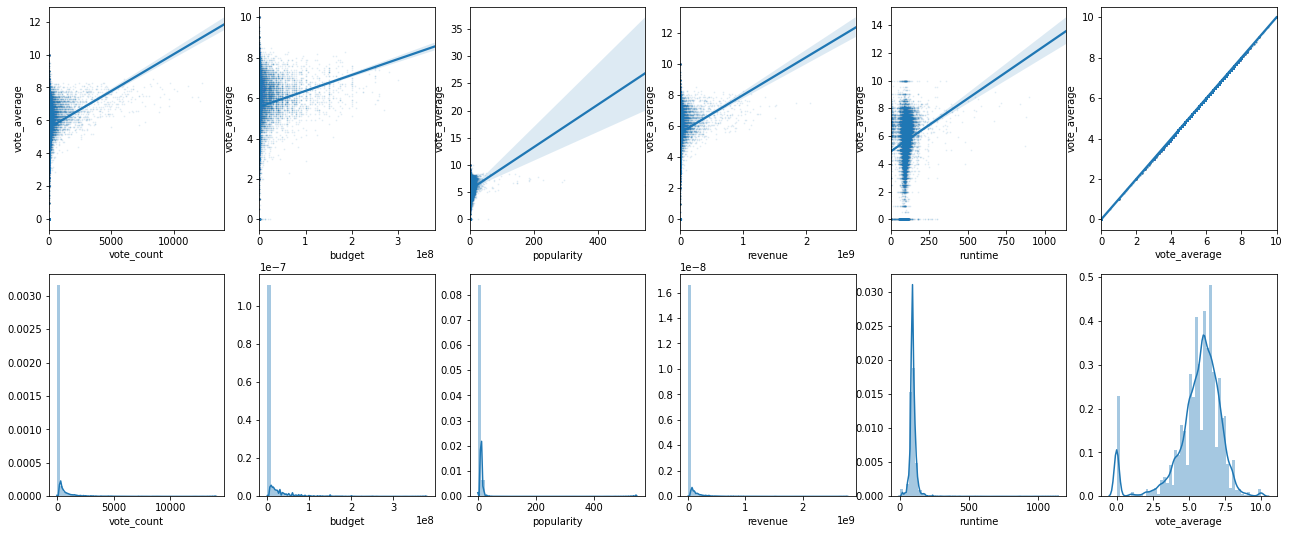

In [240]:
import seaborn as sns

numerical = overview_df.dtypes == float

fig, ax = plt.subplots(2, 6, figsize=(22,9))
for i, feature in enumerate(overview_df.columns[numerical]):
  sns.regplot(overview_df[feature], overview_df['vote_average'], ax=ax[0,i], scatter_kws={'alpha': 0.1, 's': 0.5})
  sns.distplot(overview_df[feature], ax=ax[1,i])
  
plt.show()

### Remove High Outliers

In [263]:
print(overview_df.shape)
max_vote_count = 2000
overview_df = overview_df[overview_df['vote_count'] <= max_vote_count]
print(overview_df.shape)
max_budget = 1e8
overview_df = overview_df[overview_df['budget'] <= max_budget]
print(overview_df.shape)
max_pop = 25
overview_df = overview_df[overview_df['popularity'] <= max_pop]
print(overview_df.shape)
max_revenue = 1e9
overview_df = overview_df[overview_df['revenue'] <= max_revenue]
print(overview_df.shape)
max_runtime = 200
overview_df = overview_df[overview_df['runtime'] <= max_runtime]
print(overview_df.shape)

(26909, 12)
(26407, 12)
(26283, 12)
(26252, 12)
(26252, 12)
(26083, 12)


### Remove Low Outliers

In [264]:
min_vote_count = 3
overview_df = overview_df[overview_df['vote_count'] >= min_vote_count]
print(overview_df.shape)
min_budget = 1e4
overview_df = overview_df[overview_df['budget'] >= min_budget]
print(overview_df.shape)
min_pop = 1
overview_df = overview_df[overview_df['popularity'] >= min_pop]
print(overview_df.shape)
min_revenue = 1e4
overview_df = overview_df[overview_df['revenue'] >= min_revenue]
print(overview_df.shape)
min_runtime = 30
overview_df = overview_df[overview_df['runtime'] >= min_runtime]
print(overview_df.shape)

(22092, 12)
(6137, 12)
(5714, 12)
(3891, 12)
(3890, 12)


### New Visualizations with Outliers Removed

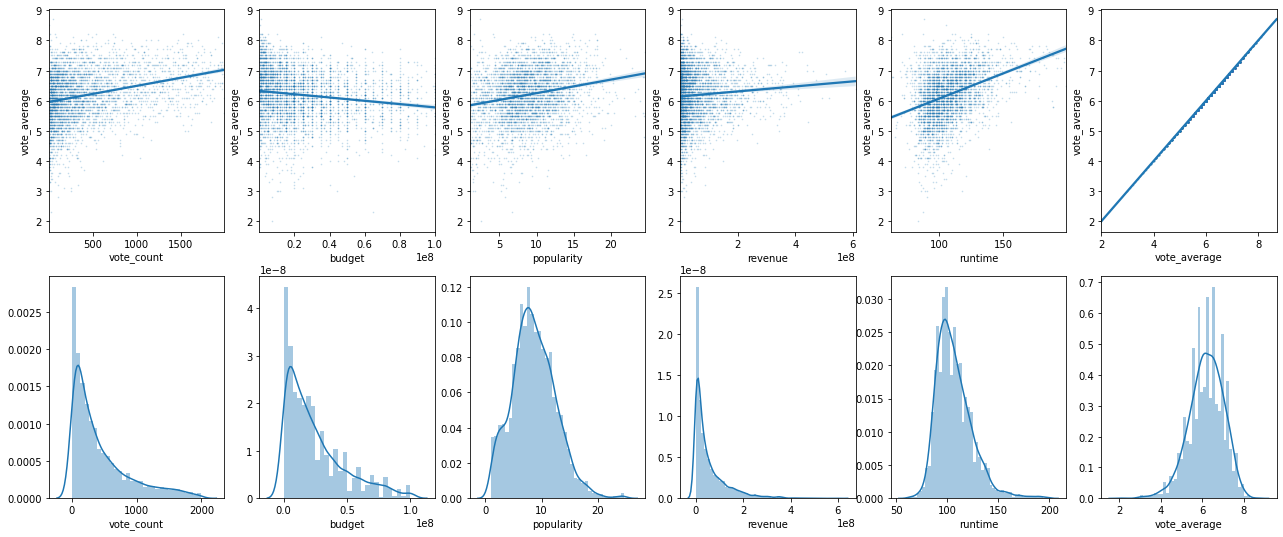

In [265]:
fig, ax = plt.subplots(2, 6, figsize=(22,9))
for i, feature in enumerate(overview_df.columns[numerical]):
  sns.regplot(overview_df[feature], overview_df['vote_average'], ax=ax[0,i], scatter_kws={'alpha': 0.2, 's': 0.5})
  sns.distplot(overview_df[feature], ax=ax[1,i])
  
plt.show()

## 3.0 Pre-Processing: Categorical Vars

### Feature Extraction: Production Company Text

In [266]:
overview_df = overview_df.dropna(subset=['production_companies'])

companies = []

for i, company in enumerate(overview_df['production_companies']):
  company = str(company)
  tmp_obj = re.search('name\': \'', company)
  try:
    start_idx = tmp_obj.span()[1]
    new_string = company[start_idx:]
  except:
    new_string = company
  try:
    end_idx = re.search('\'', new_string).span()[1] - 1
    company_name = new_string[:end_idx]
  except:
    company_name = new_string
  companies.append(company_name)

overview_df['prod_companies'] = companies
overview_df.head()

,original_title,overview,spoken_languages,vote_count,budget,genres,popularity,production_companies,revenue,runtime,vote_average,release_date,prod_companies
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[{'iso_639_1': 'en', 'name': 'English'}]",34.0,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,81452156.0,127.0,6.1,1995-12-22,Twentieth Century Fox Film Corporation
5,Heat,"Obsessive master thief, Neil McCauley leads a ...","[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",1886.0,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",17.924927,"[{'name': 'Regency Enterprises', 'id': 508}, {...",187436818.0,170.0,7.7,1995-12-15,Regency Enterprises
8,Sudden Death,International action superstar Jean Claude Van...,"[{'iso_639_1': 'en', 'name': 'English'}]",174.0,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",5.231580,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",64350171.0,106.0,5.5,1995-12-22,Universal Pictures
9,GoldenEye,James Bond must unmask the mysterious head of ...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",1194.0,58000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",14.686036,"[{'name': 'United Artists', 'id': 60}, {'name'...",352194034.0,130.0,6.6,1995-11-16,United Artists
10,The American President,"Widowed U.S. president Andrew Shepherd, one of...","[{'iso_639_1': 'en', 'name': 'English'}]",199.0,62000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",6.318445,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",107879496.0,106.0,6.5,1995-11-17,Columbia Pictures


### Remove Low-Count Production Companies

In [267]:
min_n_prods = 5

bool_series = overview_df['prod_companies'].value_counts() >= min_n_prods
tmp_dict = bool_series.to_dict()
new_dict = {}
for key, value in tmp_dict.items():
  if value == True:
    new_dict[key] = key
  else:
    new_dict[key] = np.nan
overview_df['prod_companies'] = overview_df['prod_companies'].map(new_dict)
print(overview_df.shape)
overview_df.head()

(3890, 13)


,original_title,overview,spoken_languages,vote_count,budget,genres,popularity,production_companies,revenue,runtime,vote_average,release_date,prod_companies
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[{'iso_639_1': 'en', 'name': 'English'}]",34.0,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,81452156.0,127.0,6.1,1995-12-22,Twentieth Century Fox Film Corporation
5,Heat,"Obsessive master thief, Neil McCauley leads a ...","[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",1886.0,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",17.924927,"[{'name': 'Regency Enterprises', 'id': 508}, {...",187436818.0,170.0,7.7,1995-12-15,Regency Enterprises
8,Sudden Death,International action superstar Jean Claude Van...,"[{'iso_639_1': 'en', 'name': 'English'}]",174.0,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",5.231580,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",64350171.0,106.0,5.5,1995-12-22,Universal Pictures
9,GoldenEye,James Bond must unmask the mysterious head of ...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",1194.0,58000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",14.686036,"[{'name': 'United Artists', 'id': 60}, {'name'...",352194034.0,130.0,6.6,1995-11-16,United Artists
10,The American President,"Widowed U.S. president Andrew Shepherd, one of...","[{'iso_639_1': 'en', 'name': 'English'}]",199.0,62000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",6.318445,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",107879496.0,106.0,6.5,1995-11-17,Columbia Pictures


### Feature Extraction: Genre Text

In [268]:
overview_df = overview_df.dropna(subset=['genres'])

genres = []

for i, genre in enumerate(overview_df['genres']):
  genre = str(genre)
  first_obj = re.search('}', genre)
  try:
    end_idx = first_obj.span()[0]
    new_string = genre[:end_idx]
  except:
    new_string = genre
  try:
    start_idx = re.search(':.*:', new_string).span()[1] + 1
    first_genre = new_string[start_idx:]
  except:
    first_genre = new_string
  try:
    second_genre = genre[end_idx:]
    second_obj = re.search('}', second_genre)
    try:
      end_idx = second_obj.span()[0]
      new_string = second_genre[:end_idx]
    except:
      new_string = second_genre
    try:
      start_idx = re.search(':.*:', new_string).span()[1] + 1
      second_genre = new_string[start_idx:]
    except:
      second_genre = new_string
    genres.append([first_genre, second_genre])
  except:
    genres.append([first_genre])

overview_df['proc_genres'] = [re.sub('[^A-Za-z]', '', str(genre)) for genre in genres]

### Drop Unnecessary or Redundant Features

In [271]:
cols_to_keep = ['original_title', 'overview', 'vote_count', 'vote_average', 'budget', 'proc_genres', 'popularity',
                'prod_companies', 'revenue', 'runtime', 'release_date']
overview_df = overview_df[cols_to_keep]
overview_df.head()

,original_title,overview,vote_count,vote_average,budget,proc_genres,popularity,prod_companies,revenue,runtime,release_date
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",34.0,6.1,16000000.0,Comedy,3.859495,Twentieth Century Fox Film Corporation,81452156.0,127.0,1995-12-22
5,Heat,"Obsessive master thief, Neil McCauley leads a ...",1886.0,7.7,60000000.0,Action,17.924927,Regency Enterprises,187436818.0,170.0,1995-12-15
8,Sudden Death,International action superstar Jean Claude Van...,174.0,5.5,35000000.0,Action,5.231580,Universal Pictures,64350171.0,106.0,1995-12-22
9,GoldenEye,James Bond must unmask the mysterious head of ...,1194.0,6.6,58000000.0,Adventure,14.686036,United Artists,352194034.0,130.0,1995-11-16
10,The American President,"Widowed U.S. president Andrew Shepherd, one of...",199.0,6.5,62000000.0,Comedy,6.318445,Columbia Pictures,107879496.0,106.0,1995-11-17


### Encode Datetime by Year





In [279]:
year_list = []
for date_str in overview_df['release_date']:
  year = date_str[:4]
  year = ''.join(year)
  year_list.append(year)
overview_df['date'] = year_list

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Remove Years with Few Movies

In [285]:
min_samples = 5

bool_series = overview_df['date'].value_counts() >= min_samples
tmp_dict = bool_series.to_dict()
new_dict = {key: key if value == True else np.nan for key, value in tmp_dict.items()}
overview_df['date'] = overview_df['date'].map(new_dict)
print(overview_df['date'].isna().sum())
overview_df.head()

47


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,original_title,overview,vote_count,vote_average,budget,proc_genres,popularity,prod_companies,revenue,runtime,release_date,date
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",34.0,6.1,16000000.0,Comedy,3.859495,Twentieth Century Fox Film Corporation,81452156.0,127.0,1995-12-22,1995
5,Heat,"Obsessive master thief, Neil McCauley leads a ...",1886.0,7.7,60000000.0,Action,17.924927,Regency Enterprises,187436818.0,170.0,1995-12-15,1995
8,Sudden Death,International action superstar Jean Claude Van...,174.0,5.5,35000000.0,Action,5.231580,Universal Pictures,64350171.0,106.0,1995-12-22,1995
9,GoldenEye,James Bond must unmask the mysterious head of ...,1194.0,6.6,58000000.0,Adventure,14.686036,United Artists,352194034.0,130.0,1995-11-16,1995
10,The American President,"Widowed U.S. president Andrew Shepherd, one of...",199.0,6.5,62000000.0,Comedy,6.318445,Columbia Pictures,107879496.0,106.0,1995-11-17,1995


## 4.0 Pre-Processing: Text

### Text Cleaning for Overviews

In [286]:
import re

cleaned_text = [re.sub('[^A-Za-z\s]', '', text) for text in overview_df['overview']]
overview_df['cleaned_text'] = cleaned_text
overview_df = overview_df.drop('overview', axis=1)
overview_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,original_title,vote_count,vote_average,budget,proc_genres,popularity,prod_companies,revenue,runtime,release_date,date,cleaned_text
3,Waiting to Exhale,34.0,6.1,16000000.0,Comedy,3.859495,Twentieth Century Fox Film Corporation,81452156.0,127.0,1995-12-22,1995,Cheated on mistreated and stepped on the women...
5,Heat,1886.0,7.7,60000000.0,Action,17.924927,Regency Enterprises,187436818.0,170.0,1995-12-15,1995,Obsessive master thief Neil McCauley leads a t...
8,Sudden Death,174.0,5.5,35000000.0,Action,5.231580,Universal Pictures,64350171.0,106.0,1995-12-22,1995,International action superstar Jean Claude Van...
9,GoldenEye,1194.0,6.6,58000000.0,Adventure,14.686036,United Artists,352194034.0,130.0,1995-11-16,1995,James Bond must unmask the mysterious head of ...
10,The American President,199.0,6.5,62000000.0,Comedy,6.318445,Columbia Pictures,107879496.0,106.0,1995-11-17,1995,Widowed US president Andrew Shepherd one of th...


### Lemmatize Text

In [287]:
import nltk

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [288]:
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag

# Tokenize and POS Tags
tokenized_text = [text.split() for text in overview_df['cleaned_text']]
tok_texts = [pos_tag(tok_text) for tok_text in tokenized_text]

# POS Func
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return word

# Lemmatize with POS Tags
lemmatizer = WordNetLemmatizer()
lemmatized_text = []
for text in tok_texts:
  tmp_sent = []
  for tupl in text:
    word = tupl[0]
    pos = tupl[1]
    try:
      lemm_word = lemmatizer.lemmatize(word, get_wordnet_pos(pos))
    except:
      lemm_word = word
    tmp_sent.append(lemm_word)
  full_sent = ' '.join(tmp_sent)
  lemmatized_text.append(full_sent)

# Create New Col in DF
overview_df['lemm_text'] = lemmatized_text
overview_df = overview_df.reset_index(drop=True)
overview_df.head()

,original_title,vote_count,vote_average,budget,proc_genres,popularity,prod_companies,revenue,runtime,release_date,date,cleaned_text,lemm_text
0,Waiting to Exhale,34.0,6.1,16000000.0,Comedy,3.859495,Twentieth Century Fox Film Corporation,81452156.0,127.0,1995-12-22,1995,Cheated on mistreated and stepped on the women...,Cheated on mistreat and step on the woman be h...
1,Heat,1886.0,7.7,60000000.0,Action,17.924927,Regency Enterprises,187436818.0,170.0,1995-12-15,1995,Obsessive master thief Neil McCauley leads a t...,Obsessive master thief Neil McCauley lead a to...
2,Sudden Death,174.0,5.5,35000000.0,Action,5.231580,Universal Pictures,64350171.0,106.0,1995-12-22,1995,International action superstar Jean Claude Van...,International action superstar Jean Claude Van...
3,GoldenEye,1194.0,6.6,58000000.0,Adventure,14.686036,United Artists,352194034.0,130.0,1995-11-16,1995,James Bond must unmask the mysterious head of ...,James Bond must unmask the mysterious head of ...
4,The American President,199.0,6.5,62000000.0,Comedy,6.318445,Columbia Pictures,107879496.0,106.0,1995-11-17,1995,Widowed US president Andrew Shepherd one of th...,Widowed US president Andrew Shepherd one of th...


## 5.0 Model Selection

### Train Test Split for Model Selection

In [289]:
from sklearn.model_selection import train_test_split

trim_df = overview_df.drop(['original_title', 'cleaned_text'], axis=1)

X = trim_df.drop('vote_average', axis=1)
y = trim_df['vote_average'].values

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=42)

### Preprocessor: Numerical, Categorical, and Textual Data

In [290]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer

num_cols = X_train.dtypes == float
cat_cols = ~num_cols
cat_cols[-1] = False
text_cols = 'lemm_text'
max_text_feats = 512

num_preprocessor = make_pipeline(MinMaxScaler(), SimpleImputer(strategy='median'))
cat_preprocessor = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))
text_preprocessor = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=max_text_feats)

preprocessor = make_column_transformer((num_preprocessor, num_cols),
                                       (cat_preprocessor, cat_cols),
                                       (text_preprocessor, text_cols))

### Linear Model

In [291]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(preprocessor, LinearSVR())
param_grid = {'linearsvr__C': np.logspace(-2,-1,3)}
grid = GridSearchCV(pipe, param_grid, cv=3).fit(X_train, y_train)
grid.best_score_, grid.best_params_

(0.36737458847972126, {'linearsvr__C': 0.1})

### Dense-ify matrices for Keras

In [292]:
train_matrix = preprocessor.fit_transform(X_train, y_train).todense()
val_matrix = preprocessor.transform(X_val).todense()
train_matrix.shape

(3140, 3224)

### Keras Model

In [308]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

# Model Hyperparams
n_neurons = 128
n_layers = 1
dropout_rate = 0.5

# Model
model = Sequential()
for _ in range(n_layers):
  model.add(Dense(n_neurons, activation='relu', kernel_initializer='he_normal'))
  model.add(Dropout(dropout_rate))
model.add(Dense(1))

earlystopping_cb = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
loss = keras.losses.MeanSquaredError()
metric = keras.metrics.MeanSquaredError()
model.compile(loss='mse', optimizer='adamax', metrics=['mse'])

# Training Hyperparams
epochs = 20
batch_size = 16
model.fit(train_matrix, y_train, validation_data=(val_matrix, y_val), epochs=epochs, batch_size=batch_size, callbacks=[earlystopping_cb])

Train on 3140 samples, validate on 555 samples
Epoch 1/20
3140/3140 [==============================] - 1s 182us/step - loss: 8.4381 - mse: 8.4381 - val_loss: 1.1393 - val_mse: 1.1393
Epoch 2/20
3140/3140 [==============================] - 0s 158us/step - loss: 1.3902 - mse: 1.3902 - val_loss: 0.8246 - val_mse: 0.8246
Epoch 3/20
3140/3140 [==============================] - 0s 158us/step - loss: 1.1714 - mse: 1.1714 - val_loss: 0.6731 - val_mse: 0.6731
Epoch 4/20
3140/3140 [==============================] - 0s 155us/step - loss: 1.0055 - mse: 1.0055 - val_loss: 0.5893 - val_mse: 0.5893
Epoch 5/20
3140/3140 [==============================] - 0s 156us/step - loss: 0.9299 - mse: 0.9299 - val_loss: 0.5410 - val_mse: 0.5410
Epoch 6/20
3140/3140 [==============================] - 0s 156us/step - loss: 0.8544 - mse: 0.8544 - val_loss: 0.5090 - val_mse: 0.5090
Epoch 7/20
3140/3140 [==============================] - 0s 157us/step - loss: 0.8248 - mse: 0.8248 - val_loss: 0.5129 - val_mse: 0.5129
E

In [309]:
from sklearn.metrics import r2_score

y_train_pred = model.predict(train_matrix)
y_val_pred = model.predict(val_matrix)
print(f'Train r2 score: {r2_score(y_train, y_train_pred)}\nVal r2 score: {r2_score(y_val, y_val_pred)}')

Train r2 score: 0.6063940920886468
Val r2 score: 0.32326245616994254


### XGBRegressor

In [310]:
! pip install xgboost

In [312]:
from xgboost import XGBRegressor

pipe = make_pipeline(preprocessor, XGBRegressor())
param_grid = {'xgbregressor__max_depth': [4, 6]}
grid = GridSearchCV(pipe, param_grid, cv=3).fit(X_train, y_train)
grid.best_score_, grid.best_params_

[23:00:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(0.413020829798441, {'xgbregressor__max_depth': 4})

## 7.0 Best Model Performance

In [314]:
from sklearn.metrics import r2_score

y_train_score = grid.score(X_train, y_train)
y_val_score = grid.score(X_val, y_val)
y_test_score = grid.score(X_test, y_test)

print(f'Train score: {y_train_score}\nVal score: {y_val_score}\nTest score: {y_test_score}')

Train score: 0.6598759071955964
Val score: 0.43829933379536357
Test score: 0.4164840138087448
